In [1]:
%matplotlib inline
import sys
sys.path.append("../")
sys.path.append('/home/hao/Research/probtorch/')
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from plots import *
from utils import *
from objectives import *
from torch.distributions.normal import Normal
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
import time
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [2]:
N = 300
K = 3
D = 2

## Model Parameters
MCMC_SIZE = 10
SAMPLE_SIZE = 10
NUM_HIDDEN1 = 8
STAT_SIZE = 8
NUM_LATENTS =  D
## Training Parameters
SAMPLE_DIM = 0
BATCH_DIM = 1
BATCH_SIZE = 50
NUM_EPOCHS = 10000
LEARNING_RATE = 1e-3
CUDA = torch.cuda.is_available()
PATH = 'ag-sis-idw-v1'

gpu = torch.device('cuda:1')

In [3]:
Xs = torch.from_numpy(np.load('rings_dataset/obs.npy')).float()
# STATES = torch.from_numpy(np.load('rings_dataset/states.npy')).float()
# OBS_MU = torch.from_numpy(np.load('rings_dataset/obs_mu.npy')).float()
NUM_SEQS = Xs.shape[0]
NUM_BATCHES = int((Xs.shape[0] / BATCH_SIZE))

In [4]:
class Enc_mu(nn.Module):
    def __init__(self, num_obs=D,
                       num_hidden1=NUM_HIDDEN1,
                       num_stats=STAT_SIZE,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        
        self.neural_stats = nn.Sequential(
            nn.Linear(K+D, num_hidden1),
            nn.Tanh(),
            nn.Linear(num_hidden1, num_stats),
            nn.Tanh())
        self.mean_mu = nn.Sequential(
            nn.Linear(num_stats+D, int(0.5 * num_stats+ 0.5 * D)),
            nn.Tanh(),
            nn.Linear(int(0.5 * num_stats + 0.5 * D), D))
        
        self.mean_log_sigma = nn.Sequential(
            nn.Linear(num_stats+D, int(0.5 * num_stats+ 0.5 * D)),
            nn.Tanh(),
            nn.Linear(int(0.5 * num_stats + 0.5 * D), D))

        self.prior_mu = torch.zeros((K, D))
        self.prior_sigma = torch.ones((K, D)) * 4.0
        if CUDA:
            self.prior_mu = self.prior_mu.cuda().to(gpu)
            self.prior_sigma = self.prior_sigma.cuda().to(gpu)
        
    def forward(self, obs, states, sample_size, batch_size):
        neural_stats = self.neural_stats(torch.cat((obs, states), -1))
        _, _, _, stat_size = neural_stats.shape
        cluster_size = states.sum(-2)  
        cluster_size[cluster_size == 0.0] = 1.0 # S * B * K
        neural_stats_expand = neural_stats.unsqueeze(-1).repeat(1, 1, 1, 1, K).transpose(-1, -2) ## S * B * N * K * STAT_SIZE
        states_expand = states.unsqueeze(-1).repeat(1, 1, 1, 1, stat_size) ## S * B * N * K * STAT_SIZE
        sum_stats = (states_expand * neural_stats_expand).sum(2) ## S * B * K * STAT_SIZE
        mean_stats = sum_stats / cluster_size.unsqueeze(-1)
        
        c1 = torch.cat((self.prior_mu[0].repeat(batch_size, 1).repeat(sample_size, 1, 1), mean_stats[:,:,0,:]), -1)
        c2 = torch.cat((self.prior_mu[1].repeat(batch_size, 1).repeat(sample_size, 1, 1), mean_stats[:,:,1,:]), -1)
        c3 = torch.cat((self.prior_mu[2].repeat(batch_size, 1).repeat(sample_size, 1, 1), mean_stats[:,:,2,:]), -1)
        #
        q_mu_c1 = self.mean_mu(c1)
        q_mu_c2 = self.mean_mu(c2)
        q_mu_c3 = self.mean_mu(c3)
        q_sigma_c1 = self.mean_log_sigma(c1).exp()
        q_sigma_c2 = self.mean_log_sigma(c2).exp()
        q_sigma_c3 = self.mean_log_sigma(c3).exp() 
        q_mu = torch.cat((q_mu_c1.unsqueeze(-2), q_mu_c2.unsqueeze(-2), q_mu_c3.unsqueeze(-2)), -2)
        q_sigma = torch.cat((q_sigma_c1.unsqueeze(-2), q_sigma_c2.unsqueeze(-2), q_sigma_c3.unsqueeze(-2)), -2)
        
        q = probtorch.Trace()   
        p = probtorch.Trace()
        means = Normal(q_mu, q_sigma).sample()
        q.normal(q_mu, 
                 q_sigma, 
                 value=means, 
                 name='means')
        p.normal(self.prior_mu, 
                 self.prior_sigma, 
                 value=q['means'], 
                 name='means')    
        return q, p
    
class Enc_z(nn.Module):
    def __init__(self, num_hidden=8,
                       sample_size=SAMPLE_SIZE,
                       batch_size=BATCH_SIZE):
        super(self.__class__, self).__init__()
#         self.potential = nn.Sequential(
#             nn.Linear(2, 2),
#             nn.Tanh(),
#             nn.Linear(2, 1))
        
        self.log_prob = nn.Sequential(
            nn.Linear(3, num_hidden),
            nn.Linear(num_hidden, int(0.5*num_hidden)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden), int(0.25*num_hidden)),
            nn.Tanh(),
            nn.Linear(int(0.25*num_hidden), int(0.25*num_hidden)),
            nn.Tanh(),
            nn.Linear(int(0.25*num_hidden), 1))

        self.prior_pi = torch.ones(K) * (1./ K)
        self.radius = torch.ones((sample_size, batch_size, N, 1)) *  1.5
        self.noise_sigma = torch.ones((sample_size, batch_size, N, 1)) *  0.1
        if CUDA:
            self.prior_pi = self.prior_pi.cuda().to(gpu)
            self.radius = self.radius.cuda().to(gpu)
            self.noise_sigma = self.noise_sigma.cuda().to(gpu)
  
    def forward(self, obs, obs_mu, sample_size, batch_size, decay_factor):
        obs_mu_c1 = obs_mu[:, :, 0, :].unsqueeze(-2).repeat(1,1,N,1)
        obs_mu_c2 = obs_mu[:, :, 1, :].unsqueeze(-2).repeat(1,1,N,1)
        obs_mu_c3 = obs_mu[:, :, 2, :].unsqueeze(-2).repeat(1,1,N,1)
        ## analytically compute L2 norm
        dist1 = ((obs - obs_mu_c1) ** 2).sum(-1).sqrt().unsqueeze(-1)
        dist2 = ((obs - obs_mu_c2) ** 2).sum(-1).sqrt().unsqueeze(-1)
        dist3 = ((obs - obs_mu_c3) ** 2).sum(-1).sqrt().unsqueeze(-1)
        
        pot1 = self.log_prob(torch.cat((dist1, self.radius, self.noise_sigma), -1))   
        pot2 = self.log_prob(torch.cat((dist2, self.radius, self.noise_sigma), -1))     
        pot3 = self.log_prob(torch.cat((dist3, self.radius, self.noise_sigma), -1))    

        pots = torch.cat((pot1, pot2, pot3), -1) # S * B * N * K


        q_pi = F.softmax(pots, -1)
        
        q = probtorch.Trace()
        p = probtorch.Trace()
        
        z = cat(F.softmax(pots * (1 - 0.99**decay_factor), -1)).sample()
        _ = q.variable(cat, probs=q_pi, value=z, name='zs')
        _ = p.variable(cat, probs=self.prior_pi, value=z, name='zs')
        return q, p
    
    
def initialize():
    enc_mu = Enc_mu()
    enc_z = Enc_z()
    if CUDA:
        enc_mu.cuda().to(gpu)
        enc_z.cuda().to(gpu)
    optimizer =  torch.optim.Adam(list(enc_z.parameters())+list(enc_mu.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))    
    return enc_mu, enc_z, optimizer

In [5]:
enc_mu, enc_z, optimizer = initialize()

In [11]:
EUBOs = []
ELBOs = []
ESSs = []

flog = open('results/log-' + PATH + '.txt', 'w+')
flog.write('EUBO\tELBO\tESS\n')
flog.close()
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    indices = torch.randperm(NUM_SEQS)
    EUBO = 0.0
    ELBO = 0.0
    ESS = 0.0
    for step in range(NUM_BATCHES):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        obs = Xs[batch_indices]
        obs = shuffler(obs).repeat(SAMPLE_SIZE, 1, 1, 1)
        if CUDA:
            obs = obs.cuda().to(gpu)
        eubos, elbos, esss = Eubo_v2(enc_mu, enc_z, obs, N, K, D, MCMC_SIZE, SAMPLE_SIZE, BATCH_SIZE, gpu, epoch)
        ## gradient step
        eubos.mean().backward()
        optimizer.step()
        EUBO += eubos[-1].item()
        ELBO += elbos[-1].item()
        ESS += esss[-1].item()
    EUBOs.append(EUBO / NUM_BATCHES)
    ELBOs.append(ELBO / NUM_BATCHES)
    ESSs.append(ESS / NUM_BATCHES) 
    flog = open('results/log-' + PATH + '.txt', 'a+')
    print('%.3f\t%.3f\t%.3f'
            % (EUBO/NUM_BATCHES, ELBO/NUM_BATCHES, ESS/NUM_BATCHES), file=flog)
    flog.close()
    time_end = time.time()
    print('epoch=%d, EUBO=%.3f, ELBO=%.3f, ESS=%.3f (%ds)'
            % (epoch, EUBO/NUM_BATCHES, ELBO/NUM_BATCHES, ESS/NUM_BATCHES, 
               time_end - time_start))


epoch=0, EUBO=-31578.441, ELBO=-38923.083, ESS=2.616 (11s)
epoch=1, EUBO=-31588.413, ELBO=-38774.532, ESS=2.631 (11s)
epoch=2, EUBO=-31404.689, ELBO=-38753.799, ESS=2.627 (11s)
epoch=3, EUBO=-31539.082, ELBO=-38621.414, ESS=2.658 (11s)


KeyboardInterrupt: 

CPU times: user 3.93 s, sys: 11.5 ms, total: 3.94 s
Wall time: 3.93 s


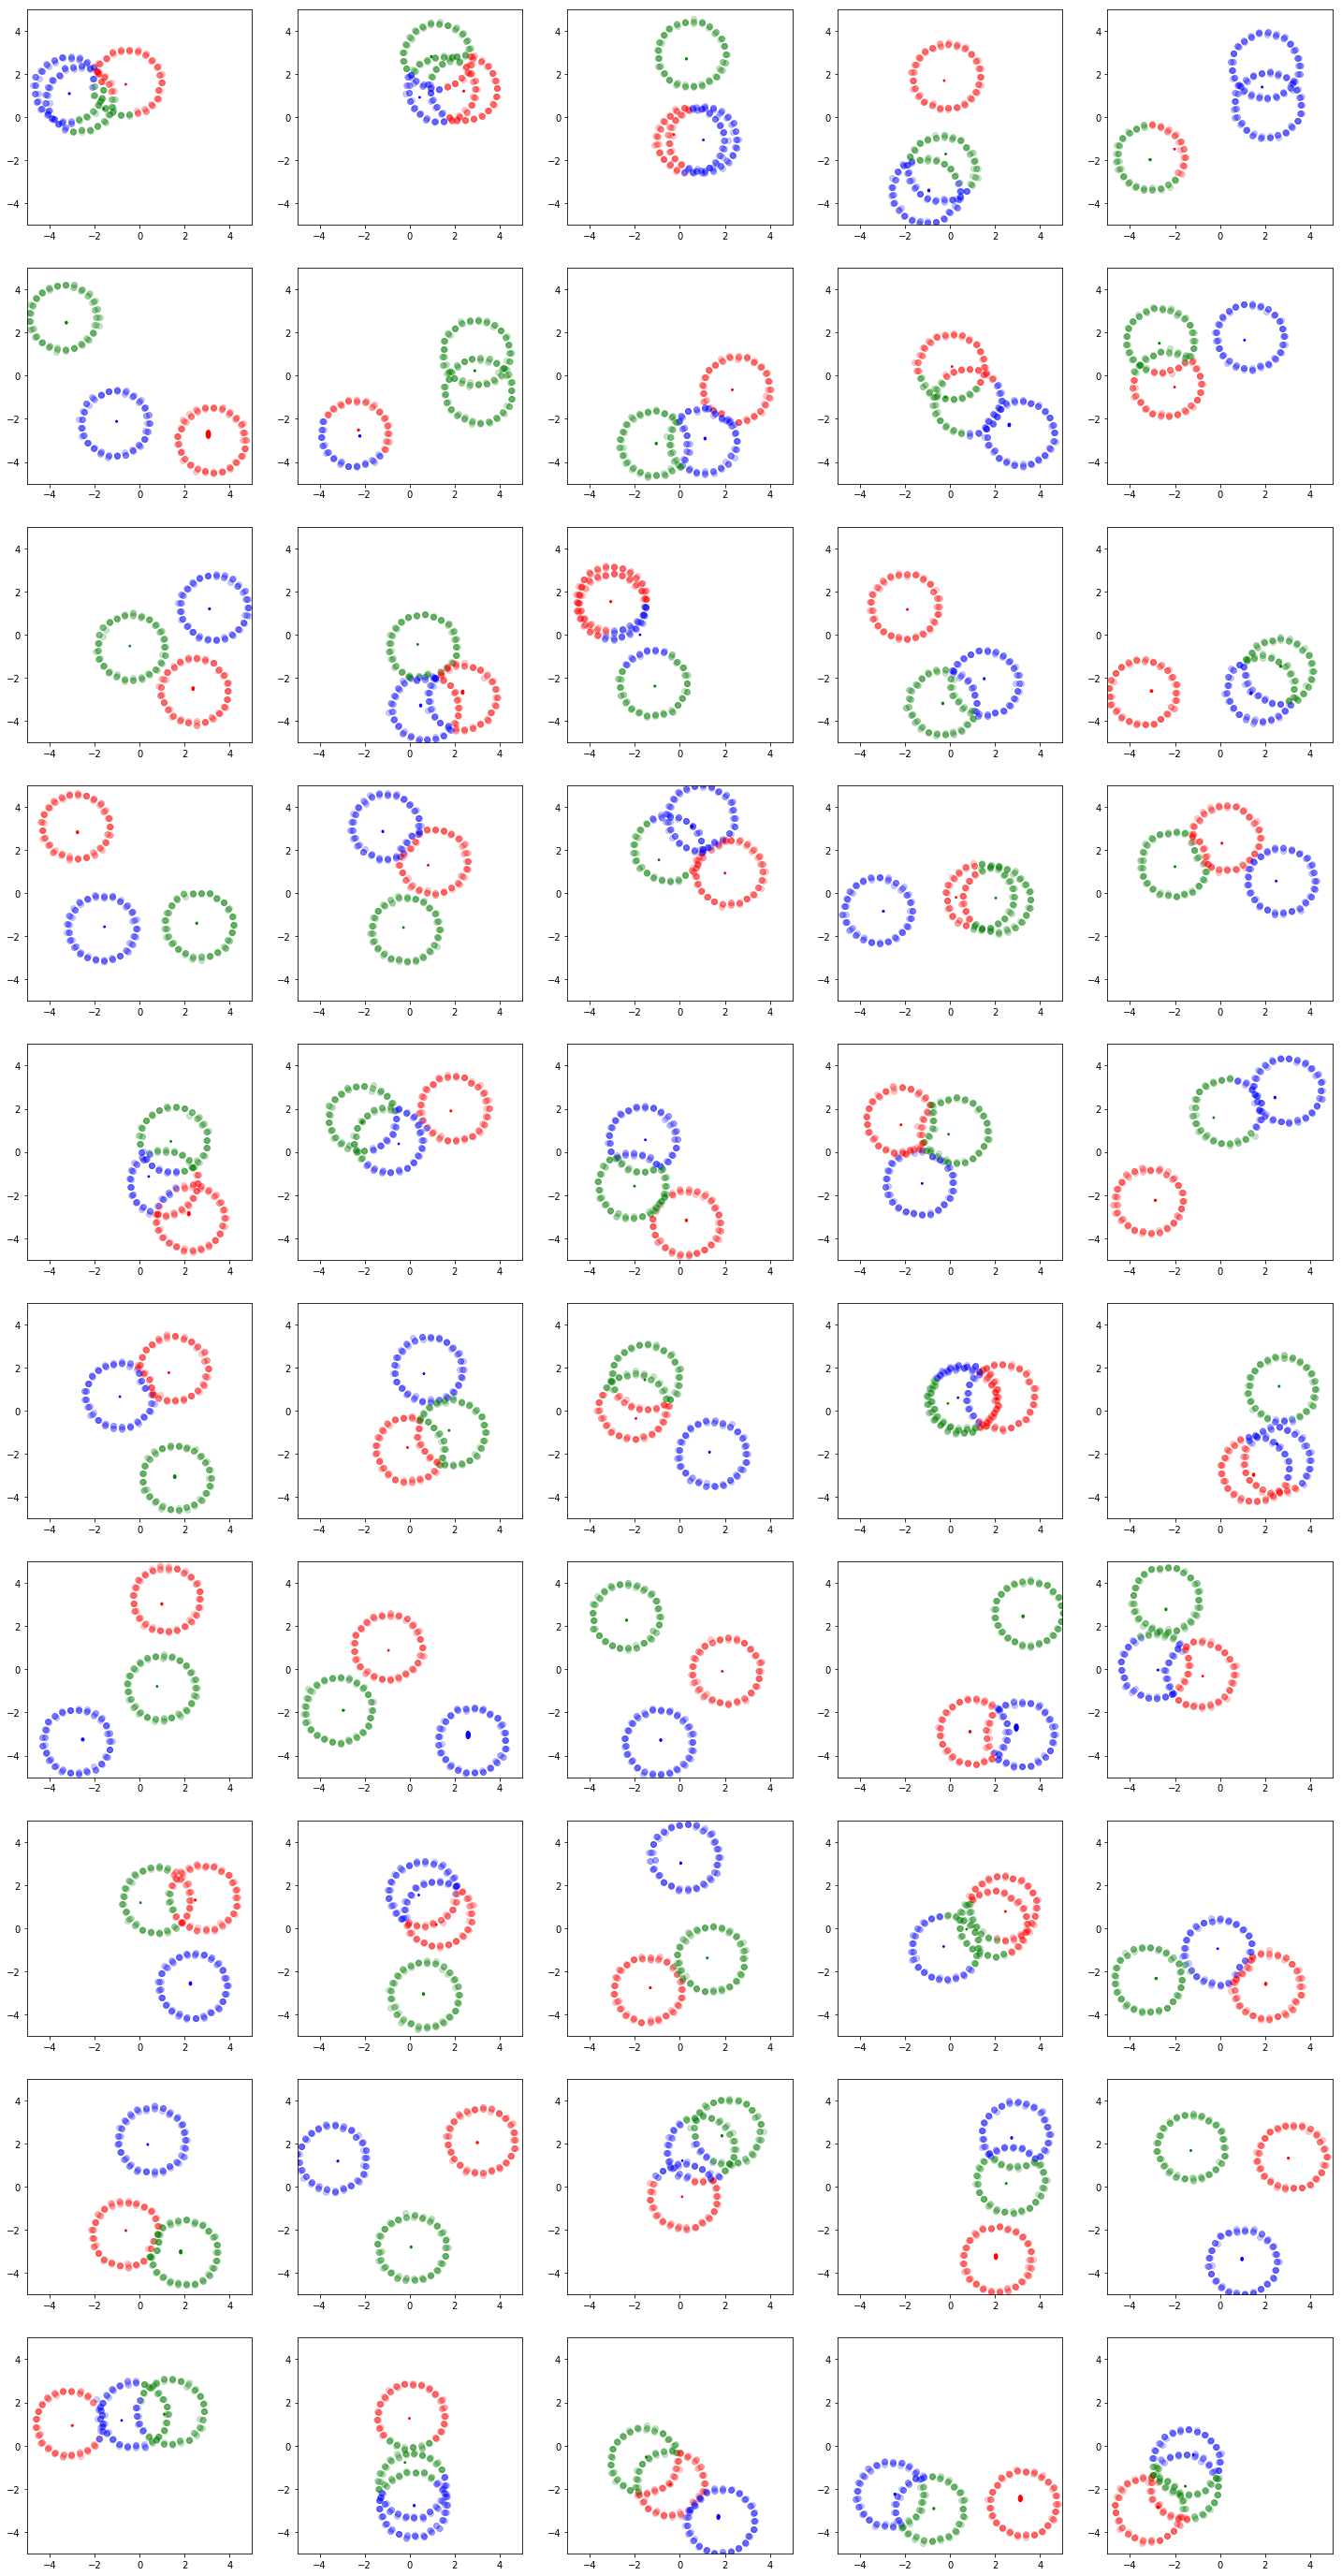

In [13]:
BATCH_SIZE_TEST = 50

def sample_single_batch(num_seqs, Xs, sample_size, batch_size, gpu):
    indices = torch.randperm(num_seqs)
    batch_indices = indices[0*batch_size : (0+1)*batch_size]
    obs = Xs[batch_indices]
    obs = shuffler(obs).repeat(sample_size, 1, 1, 1)
    if CUDA:
        obs = obs.cuda().to(gpu)
    return obs

def Log_likelihood(obs, states, obs_mu, K, D, radius, noise_sigma, gpu, cluster_flag=False):
    """
    cluster_flag = False : return S * B * N
    cluster_flag = True, return S * B * K
    """
    labels = states.argmax(-1)
    labels_flat = labels.unsqueeze(-1).repeat(1, 1, 1, D)
    obs_mu_expand = torch.gather(obs_mu, 2, labels_flat)
    distance = ((obs - obs_mu_expand)**2).sum(-1).sqrt()
    obs_dist = Normal(torch.ones(1).cuda().to(gpu) * radius, torch.ones(1).cuda().to(gpu) * noise_sigma)
    log_distance = obs_dist.log_prob(distance)
    if cluster_flag:
        log_distance = torch.cat([((labels==k).float() * log_distance).sum(-1).unsqueeze(-1) for k in range(K)], -1) # S * B * K
    return log_distance

def test(enc_mu, enc_z, obs, N, K, D, mcmc_size, sample_size, batch_size, gpu):
    p_init_z = cat(enc_z.prior_pi)
    states = p_init_z.sample((sample_size, batch_size, N,))
    log_p_z = p_init_z.log_prob(states)## S * B * N
    log_q_z = p_init_z.log_prob(states)
    for m in range(mcmc_size):
        q_mu, p_mu = enc_mu(obs, states, sample_size, batch_size)
        log_q_mu = q_mu['means'].log_prob.sum(-1)
        log_p_mu = p_mu['means'].log_prob.sum(-1) # S * B * K
        obs_mu = q_mu['means'].value
        log_obs_k = Log_likelihood(obs, states, obs_mu, K, D, radius=1.5, noise_sigma = 0.05, gpu=gpu, cluster_flag=True)
        log_weights_global = log_obs_k + log_p_mu - log_q_mu
        weights_global = F.softmax(log_weights_global, 0).detach()
        ## resample mu
        obs_mu = resample_mu(obs_mu, weights_global)
        ## update z -- cluster assignments
        q_z, p_z = enc_z(obs, obs_mu, sample_size, batch_size, 1000)
        log_p_z = p_z['zs'].log_prob
        log_q_z = q_z['zs'].log_prob ## S * B * N
        states = q_z['zs'].value
        log_obs_n = Log_likelihood(obs, states, obs_mu, K, D, radius=1.5, noise_sigma = 0.05, gpu=gpu, cluster_flag=False)
        log_weights_local = log_obs_n + log_p_z - log_q_z
        weights_local = F.softmax(log_weights_local, 0).detach()

    return q_mu, q_z

obs = sample_single_batch(NUM_SEQS, Xs, SAMPLE_SIZE, BATCH_SIZE_TEST, gpu)
q_eta, q_z = test(enc_mu, enc_z, obs, N, K, D, 500, SAMPLE_SIZE, BATCH_SIZE_TEST, gpu)
%time plot_samples(obs, q_eta, q_z, K, BATCH_SIZE_TEST, PATH)